# Automated Essay Scoring

### Objective: The goal is to develop a model that can automatically score student essays, reducing the time and expense required for hand grading.

### Importing Libraries

In [207]:
import re
import torch
import warnings
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from pandarallel import pandarallel
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import mean_squared_error, accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

warnings.filterwarnings("ignore", category=FutureWarning)

In [6]:
pandarallel.initialize()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [7]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [8]:
test.head(2)

,essay_id,full_text
0,000d118,Many people have car where they live. The thin...
1,000fe60,I am a scientist at NASA that is discussing th...


## EDA

In [9]:
df.shape

(17307, 3)

In [10]:
df.isna().sum()

essay_id     0
full_text    0
score        0
dtype: int64

In [11]:
df['full_text'][4]

'Dear, State Senator\n\nThis is a letter to argue in favor of keeping the Electoral College."There are many reasons to keep the Electoral College" one reason is because it is widely regarded as an anachronism, a dispute over the outcome of an Electoral College vote is possible, but it is less likely than a dispute over the popular vote, and the Electoral College restores some of the weight in the political balance that large states (by population) lose by virue of the mal apportionment of the Senate decreed in the Constitution.\n\nI am in favor of keeping the Electoral College because,it is widely regarded as an anachronism. A non-democratic method of selecting a president that ought to be [overruled] by declaring the canaditdate who receives the most populare votes the winner. The advocates of this position are correct in arguing that the Electoral College method is not democratic in a method sense.It is the electors who elect the the president ,not the people. But each party selects 

In [12]:
df.dtypes

essay_id     object
full_text    object
score         int64
dtype: object

<Axes: xlabel='score', ylabel='Count'>

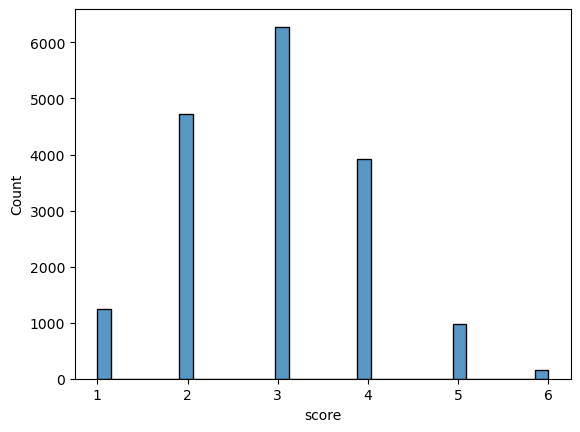

In [13]:
sns.histplot(df, x = df['score'])

In [66]:
df['Length'] = df['full_text'].apply(len)
df.sample(2)

,essay_id,full_text,score,clean_text,without_stopwords,Length
16967,fad3429,Since World War II we have been heavily depend...,5,since world war ii we have been heavily depend...,since world war ii heavily dependent modern da...,4047
10855,a02ab8f,"Dear State Senator,\n\nI think we should keep ...",3,dear state senator i think we should keep the ...,dear state senator think keep electoral colleg...,2008


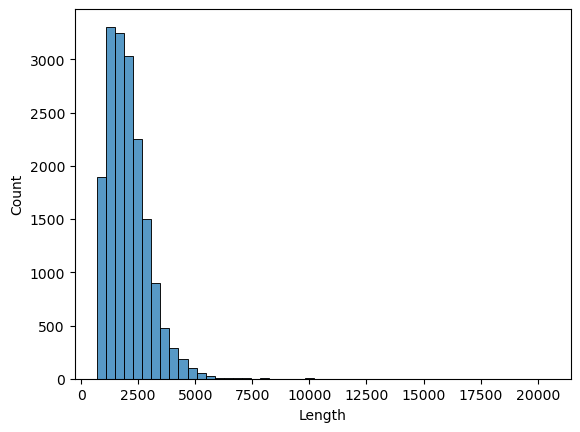

In [67]:
sns.histplot(x = 'Length',data = df,edgecolor = 'black',bins = 50)
plt.show()

### Data Pre-Processing 
### Text Cleaning: Remove unnecessary characters, stop words, and perform tokenization.

In [136]:
import string
def nonpunct(mess):
    nonpunc = [x for x in mess if x  not in string.punctuation]
    nonpunc = ''.join(nonpunc).lower()
    return nonpunc
df['full_text'] = df['full_text'].apply(nonpunct)

In [140]:
def clean_text(text):
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r"^[a-zA-Z]", "", text)
    text = text.lower()
    return text

In [141]:
df['full_text'] = df['full_text'].apply(clean_text)
df['full_text'][0]

'any people have car where they live the thing they dont know is that when you use a car alot of thing can happen like you can get in accidet or the smoke that the car has is bad to breath on if someone is walk but in vaubangermany they dont have that proble because 70 percent of vaubans families do not own carsand 57 percent sold a car to move there street parkig driveways and home garages are forbidden on the outskirts of freiburd that near the french and swiss borders you probaly wont see a car in vaubans streets because they are completely car free but if some that lives in vauban that owns a car ownership is allowedbut there are only two places that you can park a large garages at the edge of the developmentwhere a car owner buys a space but it not cheap to buy one they sell the space for you car for 40000 along with a home the vauban people completed this in 2006 they said that this an example of a growing trend in europethe untile states and some where else are suburban life fro

In [142]:
df['without_stopwords'] = df['clean_text'].parallel_apply(lambda x: ' '.join([word for word in x.split() 
                                                                    if word not in stopwords.words('english')]))

python(7423) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(7424) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(7425) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(7426) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(7427) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(7428) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(7429) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(7430) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(7431) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


### Count Vectorizer

In [196]:
y = df['score']
x = df['full_text']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state= 42, stratify= y)

In [198]:
cv = CountVectorizer()
full_text_bow = cv.fit_transform(X_train)
full_test_bow = cv.transform(X_test)

### TF-IDF

In [219]:
TT = TfidfTransformer()
text_tfidf=  TT.fit_transform(full_text_bow)
test_tfidf=  TT.transform(full_test_bow)

## Models

### Naive Bayes

In [220]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB(alpha = 0.1).fit(text_tfidf, y_train)

In [234]:
prediction = model.predict(test_tfidf)
pred = model.predict(text_tfidf)

print(accuracy_score(prediction, y_test))
print(accuracy_score(pred, y_train))

0.41392258809936455
0.6344528710725894


### Random Forest 

In [222]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
model1 = RandomForestClassifier()

In [227]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 8, 12],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [228]:
random_search = RandomizedSearchCV(model1, param_distributions=param_grid, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search.fit(text_tfidf, y_train)
prediction1 = random_search.predict(test_tfidf)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [4, 8, 12],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, scoring='accuracy')

In [231]:
pred = random_search.predict(text_tfidf)

In [233]:
print(accuracy_score(prediction1, y_test))
print(accuracy_score(pred, y_train))

0.43731946851530906
0.5570964247020586


### Logistic Regression 

In [224]:
from sklearn.linear_model import LogisticRegression
model2 = LogisticRegression(random_state=0, C=1.0, penalty='l2', solver='lbfgs', max_iter=1000).fit(text_tfidf, y_train)

In [236]:
prediction2 = model2.predict(test_tfidf)
pred = model2.predict(text_tfidf)

print(accuracy_score(prediction2, y_test))
print(accuracy_score(pred, y_train))

0.5034662045060658
0.698013723365836
